<a href="https://colab.research.google.com/github/arifpras/ExpectedDemand/blob/main/20240129_podem04.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<div class="markdown-google-sans">

  <h1> Predicting Demand in the Primary Market: Pycaret</h1>
</div>

<div class="markdown-google-sans">

## <strong> Data Preparation </strong>
</div>

## Libraries

In [1]:
%%capture

# %pip install openpyxl
# %pip install shap
# %pip install pycaret

!pip show pycaret || pip install pycaret

In [2]:
# Subsequent cells can use the installed library
import pycaret
pycaret.__version__

'3.2.0'

In [4]:
from pycaret.regression import *

import numpy as np
import pandas as pd
import openpyxl as xl
import matplotlib.pyplot as plt
import seaborn as sns

## Database

### Load

In [12]:
df_train00 = pd.read_excel('/content/drive/MyDrive/00database/db_monthfrac.xlsx', sheet_name='database')
df_train00['incoming_bid'] = df_train00['incoming_bid'].astype(float)
df_train00['issuance_date'] = pd.to_datetime(df_train00['issuance_date'], format='%Y-%m-%d')

df_train00.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1910 entries, 0 to 1909
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   issued_series     1910 non-null   object        
 1   issuance_date     1910 non-null   datetime64[ns]
 2   issuance_year     1910 non-null   int64         
 3   issuance_week     1910 non-null   int64         
 4   monthfrac         1910 non-null   int64         
 5   eid_weeks         1910 non-null   int64         
 6   srbi_issuance     1910 non-null   int64         
 7   vix_indicator     1910 non-null   int64         
 8   bi_covid          1910 non-null   int64         
 9   gso_issuance      1910 non-null   int64         
 10  investment_grade  1910 non-null   int64         
 11  incoming_bid      1910 non-null   float64       
dtypes: datetime64[ns](1), float64(1), int64(9), object(1)
memory usage: 179.2+ KB


In [13]:
df_train00['issued_series'].value_counts()

sun10    294
sun20    289
spn12    274
sun15    274
sun05    268
spn03    240
sun30    172
spn09     76
sun07     11
sun08      9
sun04      1
vr04       1
sun02      1
Name: issued_series, dtype: int64

In [14]:
df_train00.describe()

,issuance_year,issuance_week,monthfrac,eid_weeks,srbi_issuance,vix_indicator,bi_covid,gso_issuance,investment_grade,incoming_bid
count,1910.000000,1910.000000,1910.000000,1910.000000,1910.000000,1910.000000,1910.00000,1910.000000,1910.000000,1.910000e+03
mean,2017.192670,24.504188,124.277487,0.083246,0.033508,0.081675,0.24712,0.022513,0.861257,6.276664e+06
std,4.299615,14.106856,108.372190,0.276326,0.180006,0.273941,0.43145,0.148384,0.345769,5.928905e+06
min,2009.000000,1.000000,2.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000e+00
25%,2014.000000,12.000000,12.000000,0.000000,0.000000,0.000000,0.00000,0.000000,1.000000,2.376050e+06
50%,2018.000000,24.000000,119.000000,0.000000,0.000000,0.000000,0.00000,0.000000,1.000000,4.407500e+06
75%,2021.000000,37.000000,188.000000,0.000000,0.000000,0.000000,0.00000,0.000000,1.000000,8.000000e+06
max,2024.000000,51.000000,367.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,4.516780e+07


<Axes: xlabel='incoming_bid', ylabel='issuance_week'>

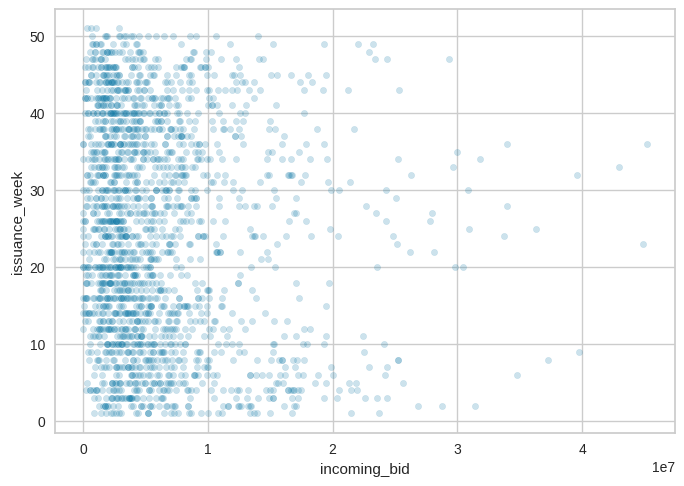

In [15]:
df_train00.plot(kind = 'scatter', x = 'incoming_bid', y = 'issuance_week', alpha = 0.2)

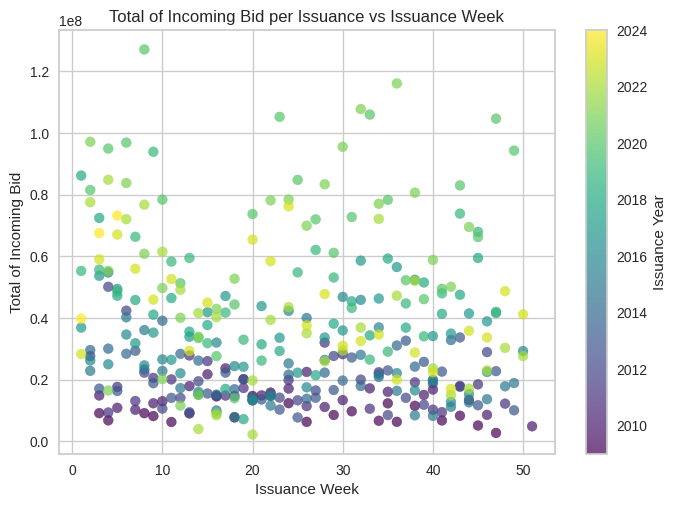

In [16]:
# import matplotlib.pyplot as plt

grouped_series01 = df_train00.groupby(['issuance_date']).agg({
    'incoming_bid': 'sum',
    'issuance_week': 'mean',
    'issuance_year': 'mean'
}).reset_index()

# Convert 'issuance_year' to integer
grouped_series01['issuance_year'] = grouped_series01['issuance_year'].astype(int)


# Scatter plot
# plt.figure(figsize=(10, 6))
plt.scatter(grouped_series01['issuance_week'], grouped_series01['incoming_bid'], s=50, c=grouped_series01['issuance_year'], alpha=0.7, cmap='viridis')
plt.title('Total of Incoming Bid per Issuance vs Issuance Week')
plt.xlabel('Issuance Week')
plt.ylabel('Total of Incoming Bid')
plt.colorbar(label='Issuance Year')
plt.grid(True)
plt.show()

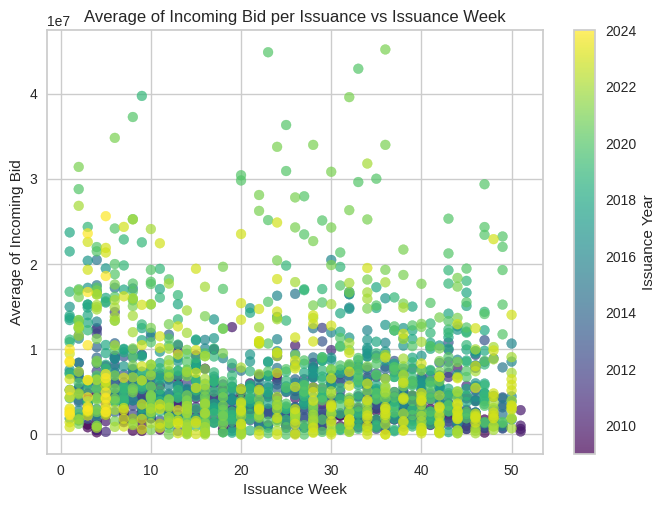

In [17]:
# import matplotlib.pyplot as plt

grouped_series02 = df_train00.groupby(['issuance_date', 'issued_series']).agg({
    'incoming_bid': 'mean', #average
    'issuance_week': 'mean',
    'issuance_year': 'mean'
}).reset_index()

# Convert 'issuance_year' to integer
grouped_series02['issuance_year'] = grouped_series02['issuance_year'].astype(int)


# Scatter plot
# plt.figure(figsize=(10, 6))
plt.scatter(grouped_series02['issuance_week'], grouped_series02['incoming_bid'], s=50, c=grouped_series02['issuance_year'], alpha=0.7, cmap='viridis')
plt.title('Average of Incoming Bid per Issuance vs Issuance Week')
plt.xlabel('Issuance Week')
plt.ylabel('Average of Incoming Bid')
plt.colorbar(label='Issuance Year')
plt.grid(True)
plt.show()

In [18]:
# sns.catplot(x='issued_series', y='incoming_bid', data=grouped_series02,
#                 kind='boxen', col='issuance_year', col_wrap=2)

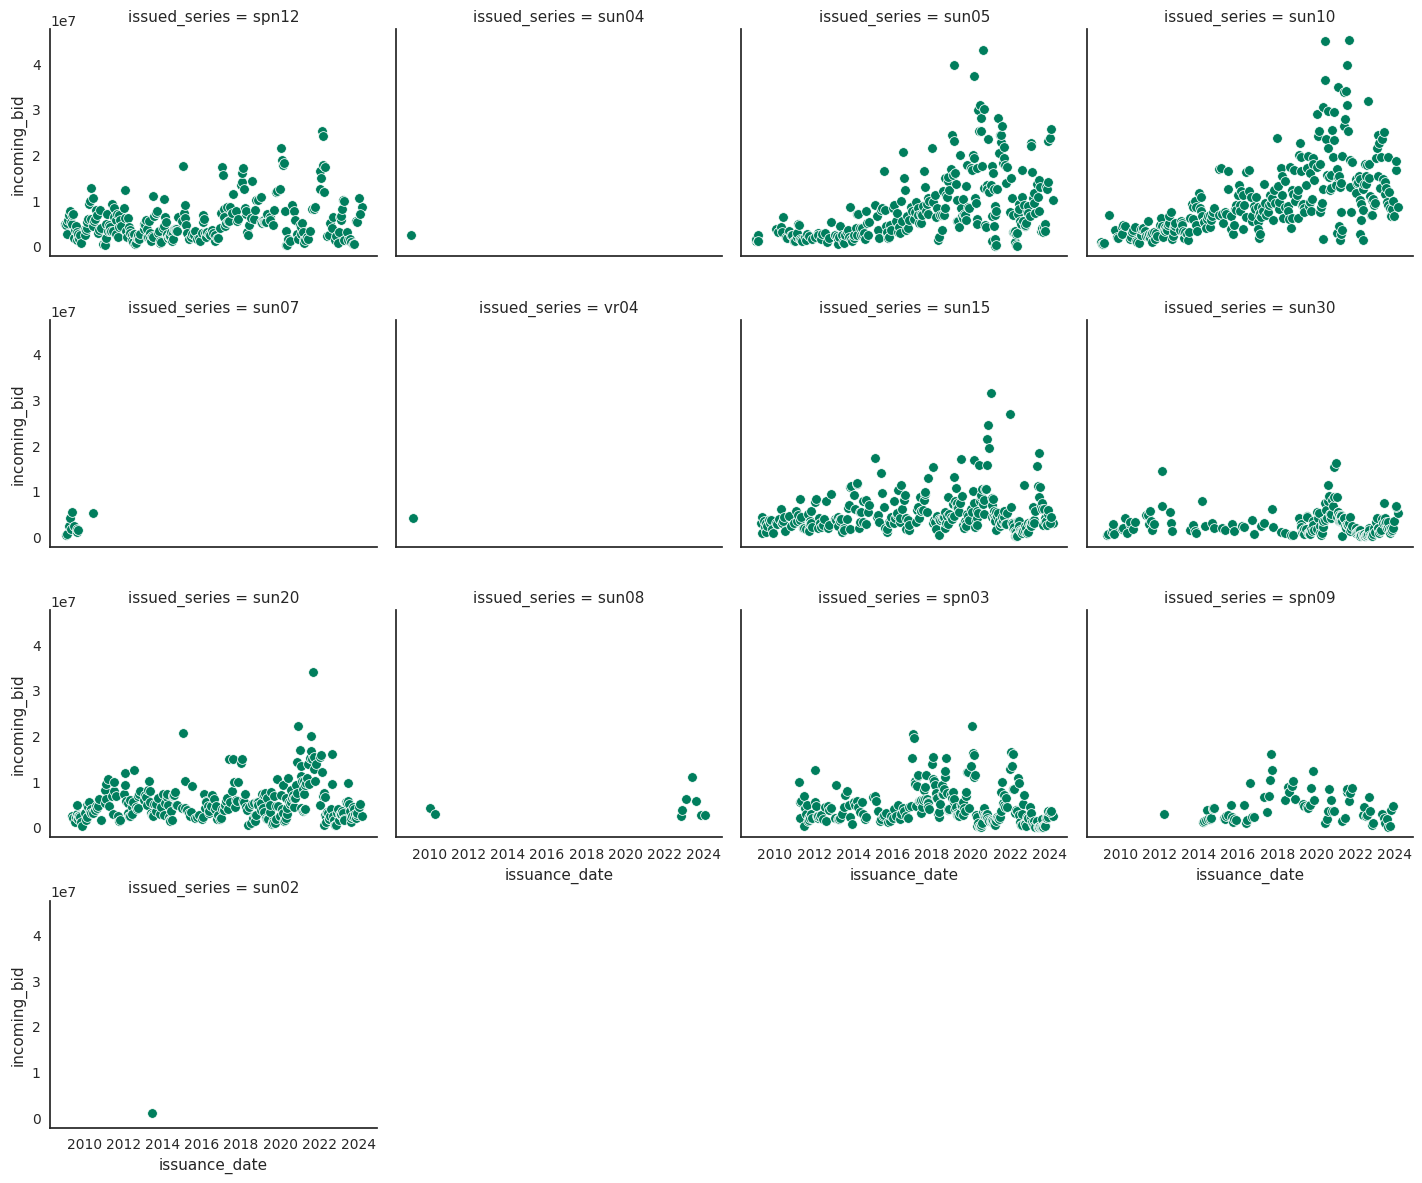

In [19]:
# import seaborn as sns
# import matplotlib.pyplot as plt

sns.set_style("white")

# Create a FacetGrid and use map to create subplots based on 'FacetVar'
ch01 = sns.FacetGrid(df_train00, col='issued_series', col_wrap=4, height=3, aspect=1.2)
ch01.map(sns.scatterplot, 'issuance_date', 'incoming_bid', color='#007e5d')

# Show the plot
# plt.show()


In [20]:
corr_matrix = df_train00.corr()
corr_matrix['incoming_bid'].sort_values(ascending=False)

incoming_bid        1.000000
issuance_year       0.249731
investment_grade    0.193119
bi_covid            0.175617
eid_weeks          -0.011341
srbi_issuance      -0.032737
vix_indicator      -0.049401
issuance_week      -0.098034
gso_issuance       -0.100544
monthfrac          -0.102453
Name: incoming_bid, dtype: float64

In [21]:
df_train01 = df_train00[~df_train00['issued_series'].isin(['sun04', 'sun02', 'vr04', 'spn09', 'sun07'])]

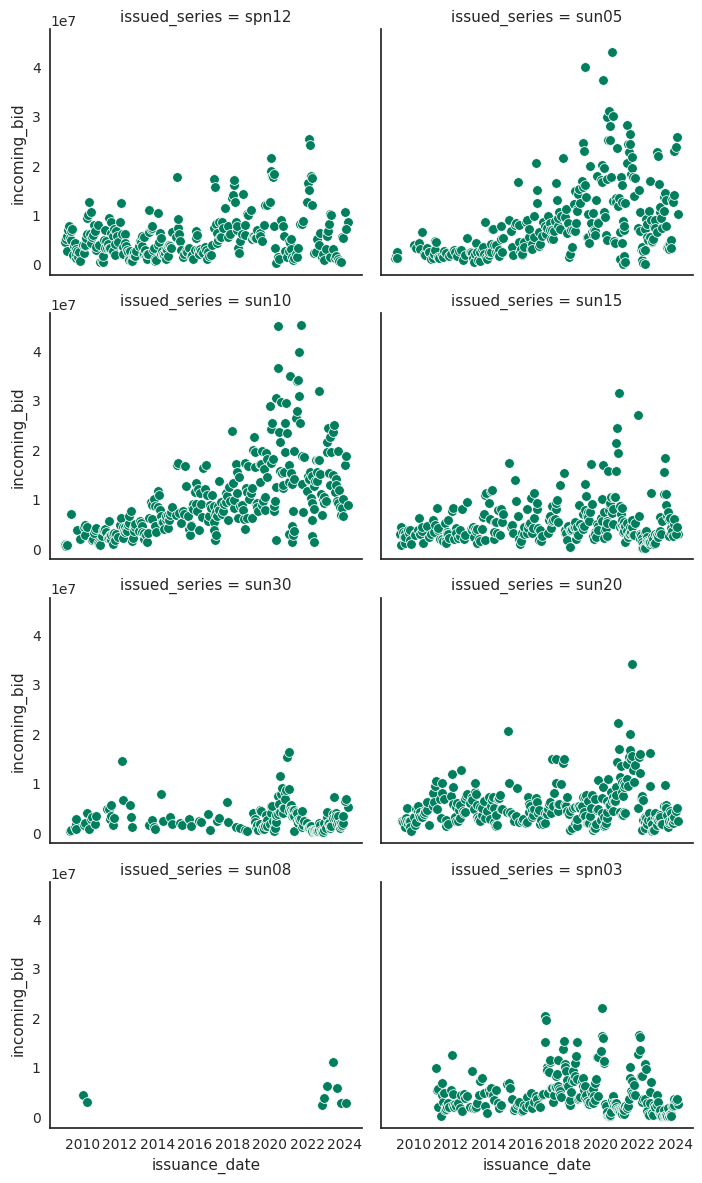

In [22]:
# import seaborn as sns
# import matplotlib.pyplot as plt

sns.set_style("white")

# Create a FacetGrid and use map to create subplots based on 'FacetVar'
ch02 = sns.FacetGrid(df_train01, col='issued_series', col_wrap=2, height=3, aspect=1.2)
ch02.map(sns.scatterplot, 'issuance_date', 'incoming_bid', color='#007e5d')

# Show the plot
# plt.show()


In [23]:
# Get the order of categories
issd_series = df_train01['issued_series'].unique()

# Sort the order
issd_series.sort()

# Create a boxplot with sorted order
# sns.boxplot(x='issued_series', y='incoming_bid', data=df_train01,
#             order=issd_series, hue='issuance_year')

# sns.boxplot(x='issued_series', y='incoming_bid', data=df_train01,
#             order=issd_series)
# plt.show()

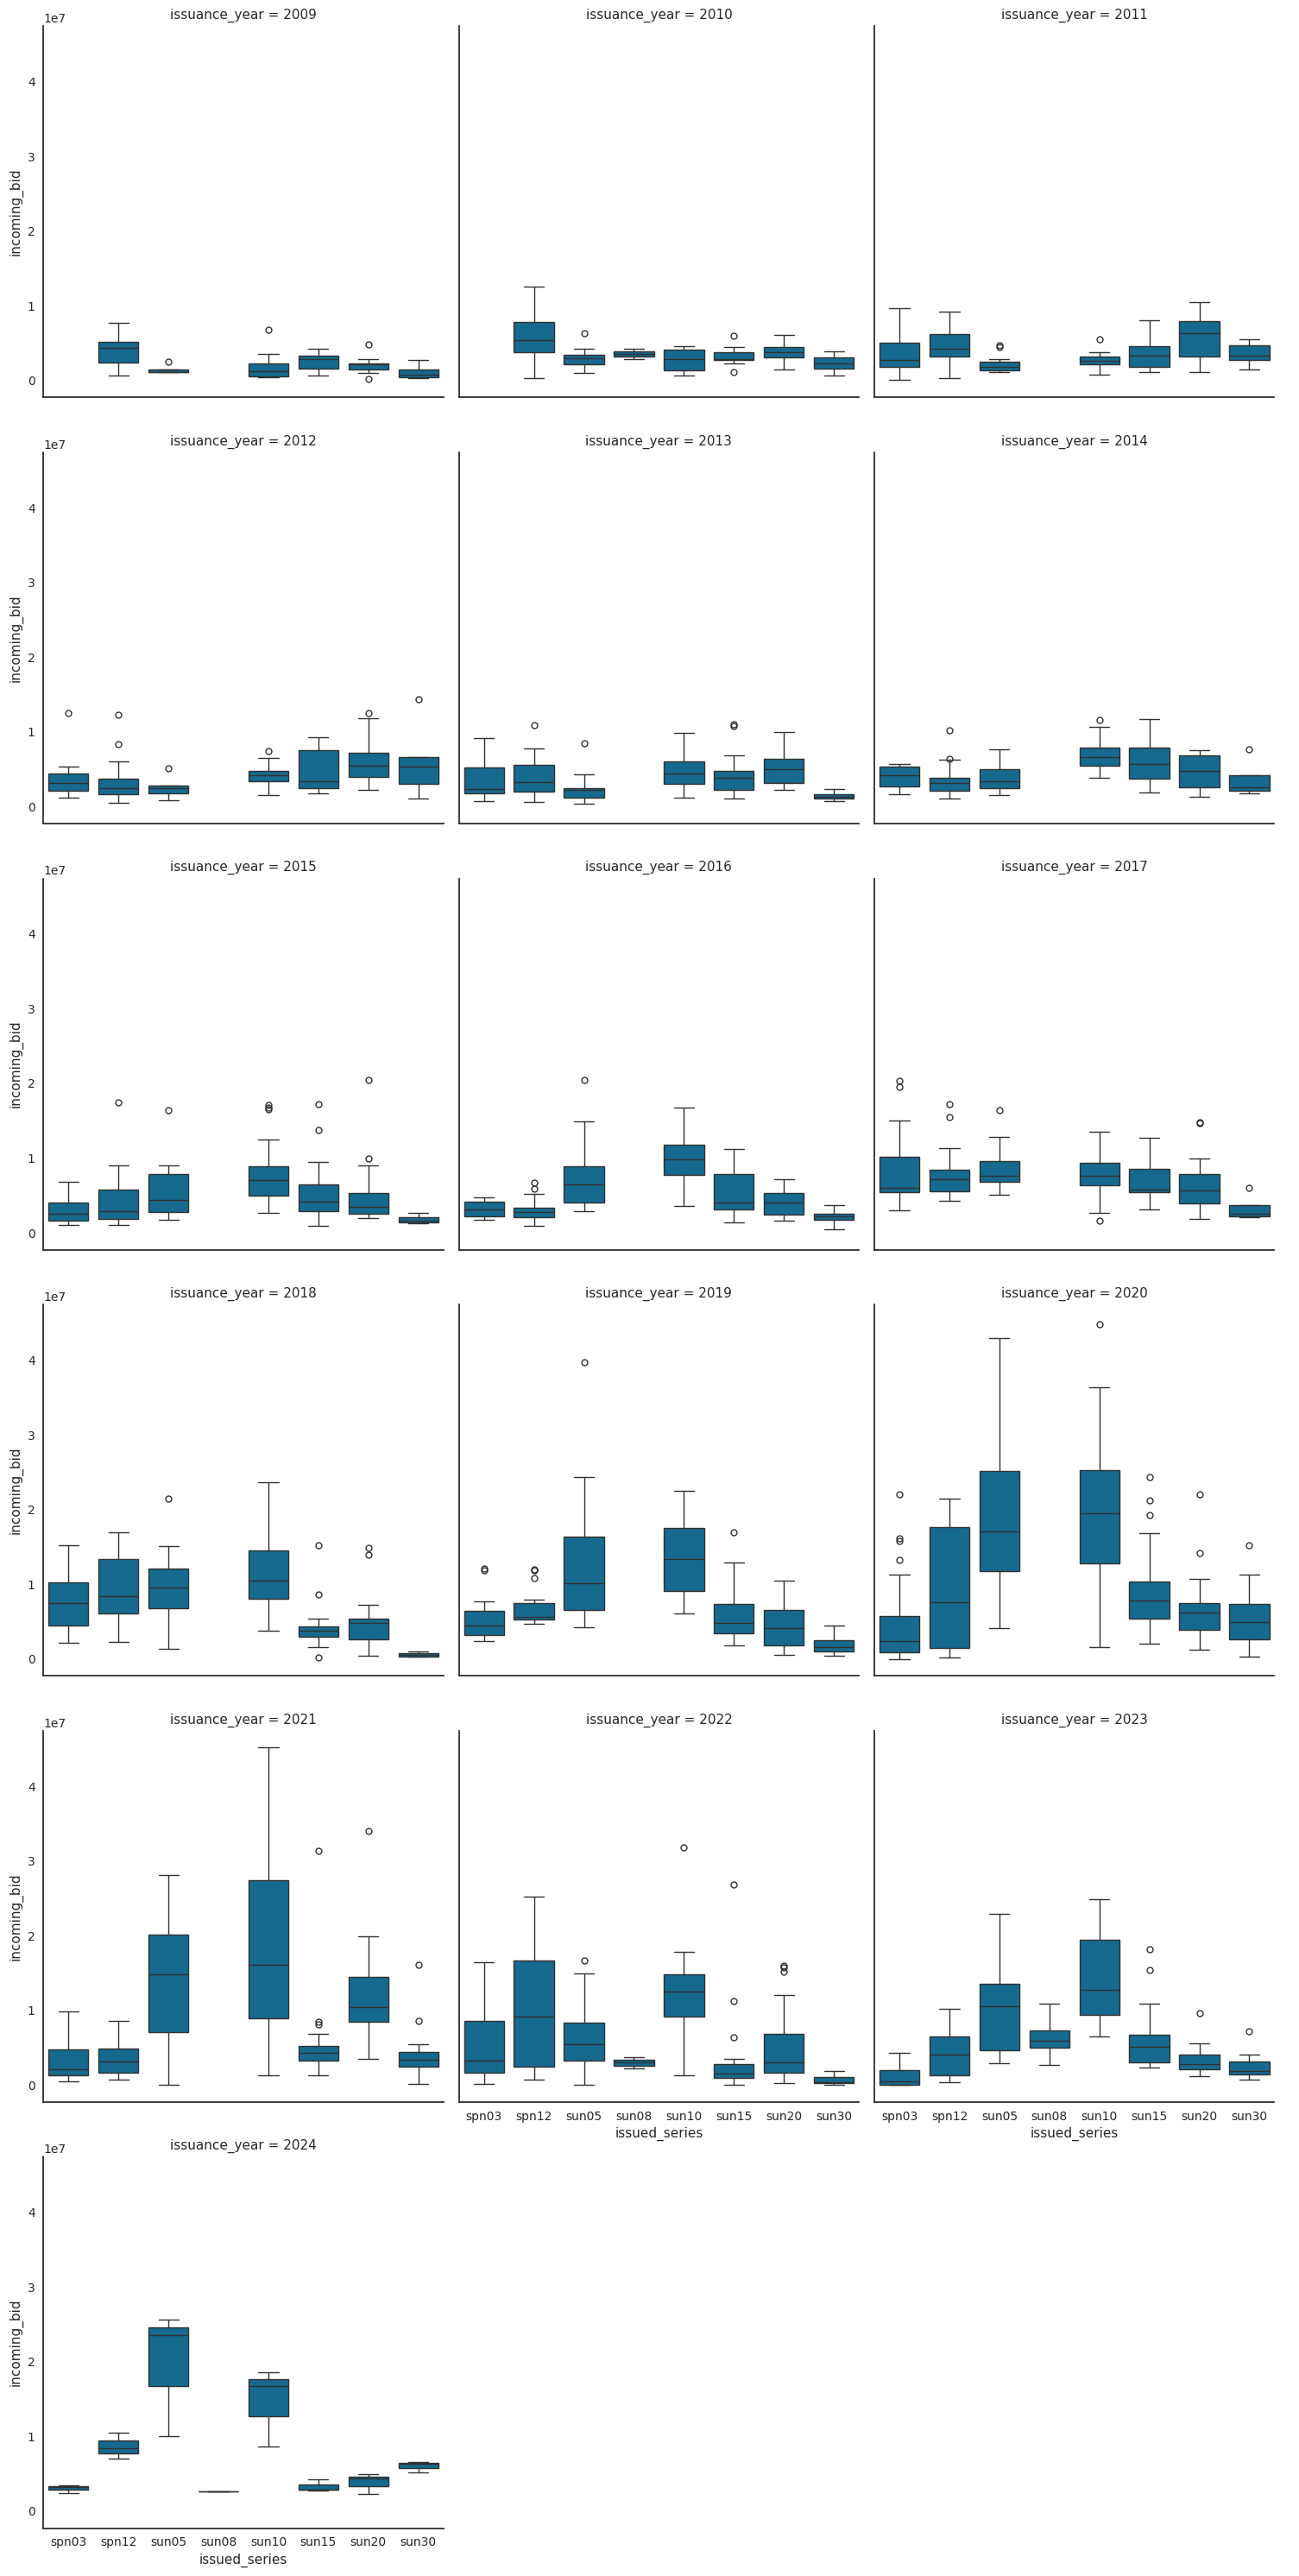

In [24]:
sns.catplot(x='issued_series', y='incoming_bid', data=df_train01,
                order=issd_series, kind='box', col='issuance_year', col_wrap=3)

### Split: Biased

In [ ]:
# df_train02 = df_train01.sample(frac=0.9, random_state=786)
# df_unseen01 = df_train01.drop(df_train02.index)

# df_train02.reset_index(drop=True, inplace=True)
# df_unseen01.reset_index(drop=True, inplace=True)

# print('Data for Modeling: ' + str(df_train02.shape))
# print('Unseen Data For Predictions: ' + str(df_unseen01.shape))

In [ ]:
# print("Train: \n{} \n\nTest: \n{}".format(df_train02['issued_series'].value_counts(), df_unseen01['issued_series'].value_counts()))

### Split: Stratified

In [ ]:
from sklearn.model_selection import StratifiedShuffleSplit

# Assuming df is your DataFrame and 'target_column' is the target variable
split = StratifiedShuffleSplit(n_splits=1, test_size=0.1, random_state=42)

for train_index, test_index in split.split(df_train01, df_train01['issued_series']):
    # Explicitly reset the index
    df_train02 = df_train01.iloc[train_index]
    df_unseen01 = df_train01.iloc[test_index]

# Explicitly reset the index for df_train02 and df_test01
# df_train02 = df_train02.reset_index(drop=True)
# df_unseen01 = df_unseen01.reset_index(drop=True)

# Display the shapes of the resulting sets (optional)
print("Train set shape:", df_train02.shape)
print("Test set shape:", df_unseen01.shape)

Train set shape: (1630, 12)
Test set shape: (182, 12)


In [ ]:
print("Train: \n{} \n\nTest: \n{}".format(df_train02['issued_series'].value_counts(), df_unseen01['issued_series'].value_counts()))

Train: 
sun10    263
sun20    259
spn12    246
sun15    246
sun05    240
spn03    215
sun30    154
sun08      7
Name: issued_series, dtype: int64 

Test: 
sun10    30
sun20    29
sun15    27
spn12    27
sun05    27
spn03    24
sun30    17
sun08     1
Name: issued_series, dtype: int64


In [ ]:
# Identifying duplicates
duplicates = df_train02[df_train02.index.duplicated()]
print("Rows with duplicate indices:")
print(duplicates)


Rows with duplicate indices:
Empty DataFrame
Columns: [issued_series, issuance_date, issuance_year, issuance_week, monthfrac, eid_weeks, srbi_issuance, vix_indicator, bi_covid, gso_issuance, investment_grade, incoming_bid]
Index: []


In [ ]:
# Identifying duplicates
duplicates = df_unseen01[df_unseen01.index.duplicated()]
print("Rows with duplicate indices:")
print(duplicates)

Rows with duplicate indices:
Empty DataFrame
Columns: [issued_series, issuance_date, issuance_year, issuance_week, monthfrac, eid_weeks, srbi_issuance, vix_indicator, bi_covid, gso_issuance, investment_grade, incoming_bid]
Index: []


# Methods

## Setup

In [ ]:
session01 = setup(data=df_train02, target='incoming_bid', session_id=123,
                  test_data=df_unseen01,
                  categorical_features=['issued_series'],
                  ignore_features = ['issuance_date'])

,Description,Value
0,Session id,123
1,Target,incoming_bid
2,Target type,Regression
3,Original data shape,"(1812, 12)"
4,Transformed data shape,"(1812, 18)"
5,Transformed train set shape,"(1630, 18)"
6,Transformed test set shape,"(182, 18)"
7,Ignore features,1
8,Numeric features,9
9,Categorical features,1


## Compare Models

In [ ]:
best01 = compare_models(sort = 'rmse')

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
xgboost,Extreme Gradient Boosting,2396009.3750,13087115470438.4004,3598570.5000,0.6389,1.2105,1.1084,0.1840
et,Extra Trees Regressor,2373463.1187,13093461371266.1797,3603983.9567,0.6391,1.0740,0.8517,0.5600
rf,Random Forest Regressor,2423749.5493,13193100897430.7891,3619436.9209,0.6354,1.2107,1.0352,0.6180
lightgbm,Light Gradient Boosting Machine,2447271.9539,13328569921635.7188,3636470.3008,0.6315,1.2160,1.0040,0.8780
gbr,Gradient Boosting Regressor,2903900.8906,17676733961263.5469,4184298.4321,0.5144,1.3166,1.1842,0.1790
knn,K Neighbors Regressor,3104857.3750,20213505772748.8008,4481349.6750,0.4394,1.3605,2.1239,0.1290
dt,Decision Tree Regressor,2918106.7485,21181184751926.3828,4581175.3524,0.4042,1.1898,1.0546,0.0950
llar,Lasso Least Angle Regression,3689649.1748,26608340670682.2383,5139113.7827,0.2677,1.5066,2.4275,0.0690
ridge,Ridge Regression,3683949.0303,26612218645025.5273,5139410.4839,0.2676,1.5061,2.4284,0.0680
lasso,Lasso Regression,3690664.3884,26612781376117.9609,5139648.6269,0.2675,1.5155,2.4266,0.0830


Processing:   0%|          | 0/81 [00:00<?, ?it/s]

## Features

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,2188960.6334,11242008960020.8457,3352910.5207,0.6295,0.6409,0.7324
1,2432628.6514,10729634503555.7188,3275612.0808,0.7192,1.7218,0.8530
2,2379804.0244,11942117931311.8926,3455736.9592,0.6065,1.3270,0.7089
3,2522025.7380,15061012788290.6875,3880852.0699,0.6825,1.6754,0.6674
4,2702509.4181,16218963950536.5312,4027277.4862,0.6475,0.9448,3.1075
5,2362202.3378,10554427007551.4902,3248757.7638,0.6312,0.6382,0.7314
6,2590267.1603,18392262510441.2109,4288620.1173,0.6025,1.2950,0.9761
7,2312924.9026,13314446219952.1719,3648896.5757,0.5432,1.4728,0.5853
8,2430792.3357,12376604234232.5469,3518039.8284,0.6524,1.7480,0.7436


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

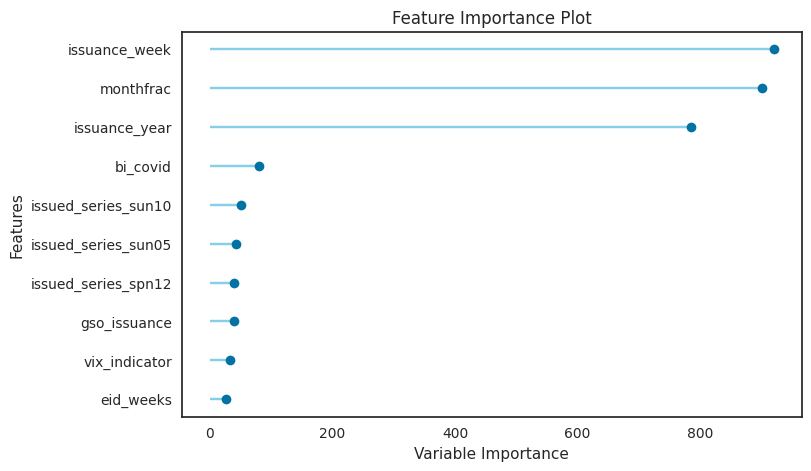

In [ ]:
plot_model(create_model('lightgbm'), plot='feature')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,2160377.2500,9289076834304.0000,3047798.7500,0.6939,0.6931,0.6689
1,2392128.7500,12066079375360.0000,3473626.2500,0.6842,1.6351,0.7843
2,2294340.2500,10501864030208.0000,3240658.0000,0.6539,1.3663,0.6512
3,2562119.5000,16734597677056.0000,4090794.2500,0.6472,1.6202,0.6196
4,2811414.0000,18026971791360.0000,4245818.0000,0.6082,1.0245,4.8159
5,2366754.5000,10546608865280.0000,3247554.2500,0.6315,0.6575,0.7757
6,2343251.2500,14164775927808.0000,3763612.0000,0.6939,1.1803,0.6825
7,2375055.0000,15150035763200.0000,3892304.7500,0.4802,1.4739,0.5651
8,2377396.2500,12585540780032.0000,3547610.5000,0.6465,1.7825,0.6669


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

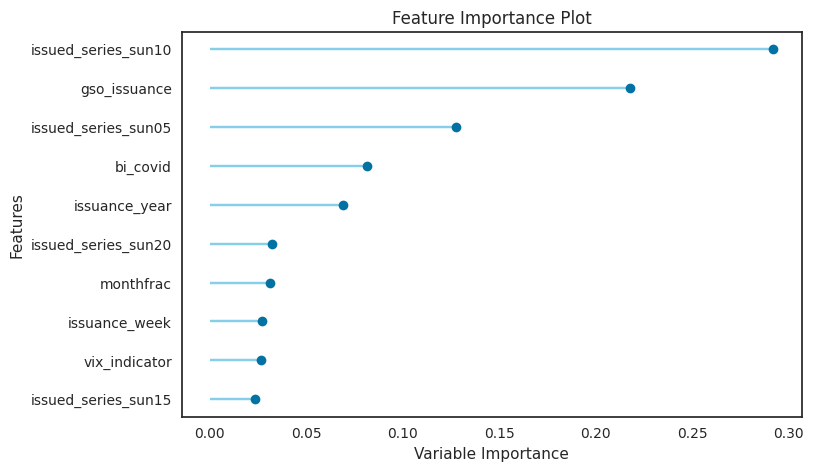

In [ ]:
plot_model(create_model('xgboost'), plot='feature')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,2205912.2638,11153570387875.4785,3339696.1520,0.6324,0.5743,0.5639
1,2514759.3466,13819176070976.7969,3717415.2406,0.6384,1.4859,0.7360
2,2116435.3742,10080849413953.3984,3175035.3406,0.6678,0.7078,0.4571
3,2581163.3252,17812235895068.3086,4220454.4655,0.6245,1.6809,0.6067
4,2480963.1595,15747027617168.0938,3968252.4639,0.6578,0.8433,2.6880
5,2217874.3497,9806186822931.1602,3131483.1666,0.6573,0.6025,0.6458
6,2458333.5460,14137782446092.0254,3760024.2614,0.6945,1.2306,0.6788
7,2356441.6871,13515366104485.2090,3676325.0814,0.5363,1.3924,0.5797
8,2422833.0307,12156447154493.8066,3486609.6935,0.6585,1.5730,0.6163


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

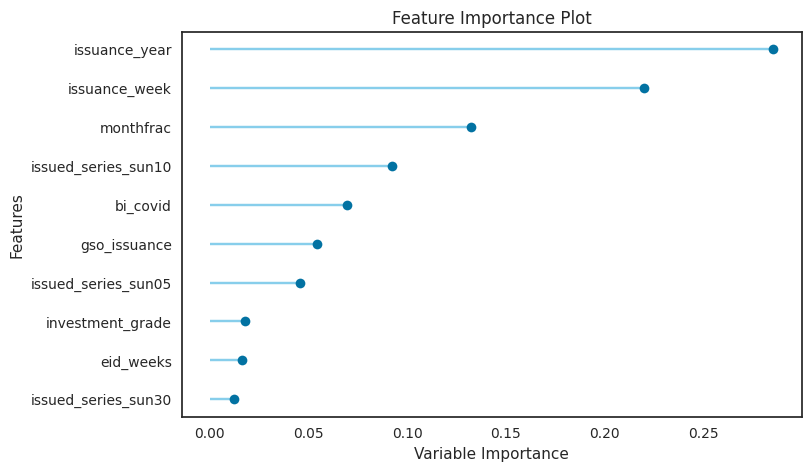

In [ ]:
plot_model(create_model('et'), plot='feature')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,2192232.0026,10627323099708.8965,3259957.5304,0.6498,0.6092,0.6663
1,2541333.1955,13055397565521.1426,3613225.3688,0.6583,1.6939,0.9258
2,2207692.1441,9567038746623.1035,3093063.0040,0.6847,1.2946,0.5451
3,2560308.2910,16332751004593.8535,4041379.8392,0.6557,1.6972,0.6923
4,2568544.2367,15484155477867.2344,3934991.1662,0.6635,0.9087,3.5915
5,2324166.0757,10652876894169.4043,3263874.5218,0.6278,0.6305,0.7140
6,2446142.4100,15528352983698.1543,3940603.1244,0.6644,1.2654,0.8746
7,2363401.9100,13846503940091.0000,3721089.0798,0.5249,1.6240,0.6287
8,2500807.0450,13473061387137.4883,3670566.9027,0.6216,1.7003,0.7254


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

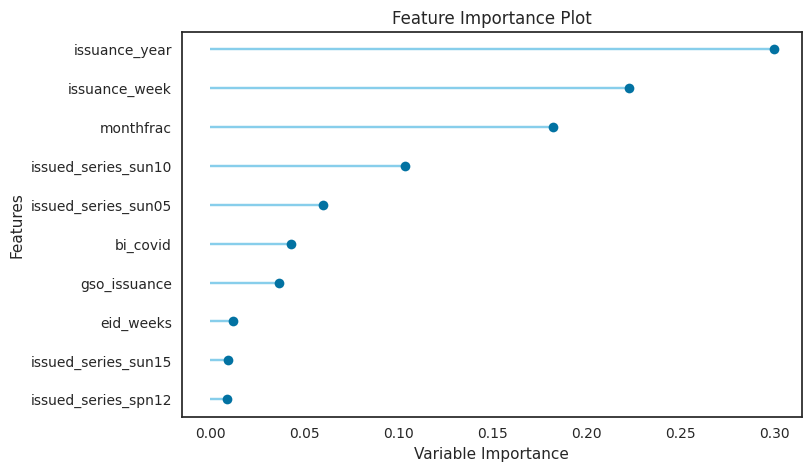

In [ ]:
plot_model(create_model('rf'), plot='feature')

# Algorithms

## Light Gradient Boosting Machine

### Raw -- 63.15%

In [ ]:
# train a xgb model with default params
lightgbm_raw = create_model('lightgbm')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,2188960.6334,11242008960020.8457,3352910.5207,0.6295,0.6409,0.7324
1,2432628.6514,10729634503555.7188,3275612.0808,0.7192,1.7218,0.8530
2,2379804.0244,11942117931311.8926,3455736.9592,0.6065,1.3270,0.7089
3,2522025.7380,15061012788290.6875,3880852.0699,0.6825,1.6754,0.6674
4,2702509.4181,16218963950536.5312,4027277.4862,0.6475,0.9448,3.1075
5,2362202.3378,10554427007551.4902,3248757.7638,0.6312,0.6382,0.7314
6,2590267.1603,18392262510441.2109,4288620.1173,0.6025,1.2950,0.9761
7,2312924.9026,13314446219952.1719,3648896.5757,0.5432,1.4728,0.5853
8,2430792.3357,12376604234232.5469,3518039.8284,0.6524,1.7480,0.7436


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

### Tuning -- 58.95%

In [ ]:
# tune hyperparameters of lightgbm
lightgbm_tuned = tune_model(lightgbm_raw)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,2473014.5916,14314518879883.9316,3783453.3009,0.5282,0.8075,0.7409
1,2770845.8721,13931222135849.4844,3732455.2423,0.6354,1.7711,1.0041
2,2610895.1602,12934680828248.5977,3596481.7292,0.5737,1.3695,0.8850
3,2754012.9874,17184850184417.1621,4145461.3958,0.6377,1.6281,0.7743
4,2738704.1076,16238755230271.6934,4029733.8908,0.6471,1.0927,4.8209
5,2735023.5152,12865655822492.2109,3586872.7079,0.5504,0.7965,0.8765
6,2715028.3477,18043958909039.2656,4247818.1351,0.6101,1.3086,1.0299
7,2617778.8713,14958562693840.1094,3867630.1134,0.4867,1.7916,0.7422
8,2657566.4441,14447770310838.0312,3801022.2718,0.5942,1.7204,0.7933


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 10 folds for each of 10 candidates, totalling 100 fits


Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


### Modifying -- 64.75%

In [ ]:

# Define a more comprehensive tuning grid for LightGBM
lightgbm_grid = {
    'learning_rate': [0.001, 0.01, 0.1, 0.2, 0.3, 0.5],
    'n_estimators': [50, 100, 200, 300],
    'max_depth': [3, 5, 7, 9, 11],
    'min_child_weight': [1, 3, 5],
    'subsample': [0.6, 0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1.0],
    'reg_alpha': [0, 0.1, 0.01, 0.001],
    'reg_lambda': [1, 1.5, 2, 3, 4],
    'num_leaves': [15, 31, 63, 127],
    'min_split_gain': [0, 0.1, 0.2, 0.3, 0.4],
    'subsample_freq': [0, 1, 2],
}

# Tune LightGBM model with custom grid and optimize for R2
lightgbm_modified = tune_model(lightgbm_raw, custom_grid=lightgbm_grid, optimize='mse', early_stopping=True, choose_better=True)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,2092735.8505,9854076391683.6973,3139120.3213,0.6752,0.7343,0.6522
1,2463170.7817,11316221130439.2500,3363959.1452,0.7039,1.6682,0.8170
2,2477651.5162,12712792102707.5039,3565500.2598,0.5811,1.3823,0.7605
3,2507451.4735,14809485731869.0391,3848309.4642,0.6878,1.6974,0.6484
4,2625306.7748,15491024571939.1973,3935863.8914,0.6633,0.9619,2.3624
5,2238711.8031,9598041095288.7402,3098070.5439,0.6646,0.6299,0.7162
6,2407160.0683,14796661498743.7129,3846642.8868,0.6802,1.2642,0.7660
7,2366976.4877,13581871989407.9629,3685359.1398,0.5340,1.6071,0.5955
8,2370284.7271,12363946020402.3086,3516240.3246,0.6527,1.7770,0.7079


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 10 folds for each of 10 candidates, totalling 100 fits


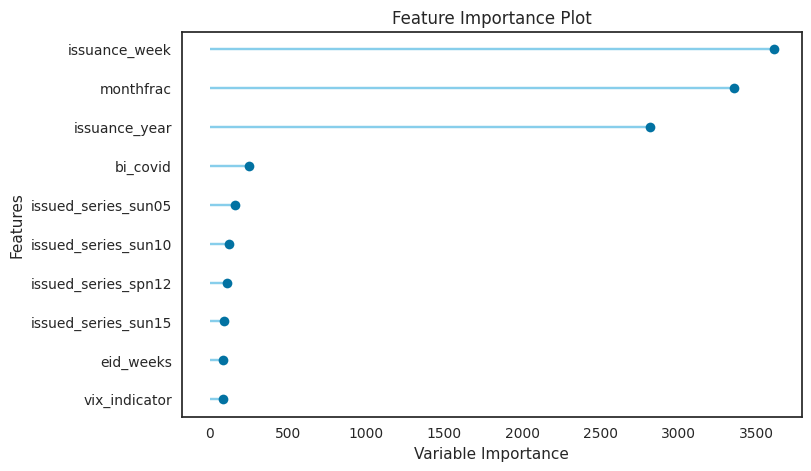

In [ ]:
plot_model(lightgbm_modified, plot = 'feature')

### Bagging -- 62.68%

In [ ]:
# ensemble with bagging
lightgbm_bagged = ensemble_model(lightgbm_raw, method = 'Bagging')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,2175187.4570,10933784097064.8301,3306627.2994,0.6397,0.6514,0.7355
1,2608690.7338,12555397104506.3730,3543359.5788,0.6714,1.7374,0.9019
2,2470908.7685,11765836323278.5098,3430136.4876,0.6123,1.3319,0.7210
3,2565097.8616,16056164752626.6230,4007014.4438,0.6615,1.5532,0.7368
4,2696173.2601,15800883602622.0859,3975032.5285,0.6566,0.9174,2.7669
5,2398316.1437,10693630911171.3184,3270111.7582,0.6263,0.6496,0.7560
6,2656765.8133,18388450190233.4648,4288175.6249,0.6026,1.3068,0.9717
7,2351499.9621,13799665397489.6660,3714790.0879,0.5265,1.4803,0.6279
8,2429735.9522,12635762981990.4531,3554681.8398,0.6451,1.8189,0.7426


Processing:   0%|          | 0/6 [00:00<?, ?it/s]

### Boosting -- 63.21%

In [ ]:
# ensemble with boosting
lightgbm_boosted = ensemble_model(lightgbm_raw, method = 'Boosting')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,2157981.3569,10118069013090.2598,3180891.2294,0.6665,0.6596,0.7533
1,2619148.9328,12505914217382.8711,3536370.2037,0.6727,1.7061,0.9020
2,2526148.2598,13385032894625.4199,3658556.1216,0.5589,1.3547,0.7635
3,2484022.8545,14175773876598.2090,3765072.8913,0.7012,1.5239,0.7263
4,2656479.2464,15314667960289.4648,3913395.9626,0.6672,0.8982,2.2069
5,2294886.9857,9573475941183.9414,3094103.4148,0.6655,0.6502,0.7539
6,2502477.3053,16321690995690.8613,4040011.2618,0.6473,1.4016,0.8969
7,2448719.4554,14476782881692.7383,3804836.7746,0.5033,1.5817,0.6316
8,2554551.8047,12738153312203.7012,3569054.9607,0.6422,1.7953,0.8011


Processing:   0%|          | 0/6 [00:00<?, ?it/s]

## Extreme Gradient Boosting

### Raw -- 63.89%

In [ ]:
# train a xgb model with default params
xgb_raw = create_model('xgboost')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,2160377.2500,9289076834304.0000,3047798.7500,0.6939,0.6931,0.6689
1,2392128.7500,12066079375360.0000,3473626.2500,0.6842,1.6351,0.7843
2,2294340.2500,10501864030208.0000,3240658.0000,0.6539,1.3663,0.6512
3,2562119.5000,16734597677056.0000,4090794.2500,0.6472,1.6202,0.6196
4,2811414.0000,18026971791360.0000,4245818.0000,0.6082,1.0245,4.8159
5,2366754.5000,10546608865280.0000,3247554.2500,0.6315,0.6575,0.7757
6,2343251.2500,14164775927808.0000,3763612.0000,0.6939,1.1803,0.6825
7,2375055.0000,15150035763200.0000,3892304.7500,0.4802,1.4739,0.5651
8,2377396.2500,12585540780032.0000,3547610.5000,0.6465,1.7825,0.6669


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

### Tuning -- 63.88%

In [ ]:
# tune hyperparameters of xgb
xgb_tuned = tune_model(xgb_raw)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,2039635.2500,9474016280576.0000,3077989.0000,0.6878,0.6175,0.5979
1,2541052.7500,13040542023680.0000,3611169.0000,0.6587,1.7603,0.8115
2,2477813.2500,12841121742848.0000,3583451.0000,0.5768,1.4310,0.7009
3,2441709.2500,14321719443456.0000,3784404.7500,0.6981,1.4867,0.6273
4,2694974.7500,17224487141376.0000,4150239.5000,0.6257,1.0973,2.3999
5,2310782.7500,9461536129024.0000,3075961.0000,0.6694,0.6466,0.6887
6,2435061.5000,14667507302400.0000,3829818.2500,0.6830,1.3076,0.6692
7,2395597.7500,14175961088000.0000,3765097.7500,0.5136,1.6348,0.6396
8,2482327.2500,12172802392064.0000,3488954.2500,0.6581,1.7803,0.6832


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 10 folds for each of 10 candidates, totalling 100 fits


Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


### Modifying -- 65.70%

In [ ]:
# define a more comprehensive tuning grid for XGBoost
xgb_grid = {
    'learning_rate': [0.001, 0.01, 0.1, 0.2, 0.3, 0.5],
    'n_estimators': [50, 100, 200, 300],
    'max_depth': [3, 5, 7, 9, 11],
    'min_child_weight': [1, 3, 5],
    'subsample': [0.6, 0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1.0],
    'gamma': [0, 0.1, 0.2, 0.3, 0.4],
    'reg_alpha': [0, 0.1, 0.01, 0.001],
    'reg_lambda': [1, 1.5, 2, 3, 4]
}

# tune model with custom grid and optimize for R2
xgb_modified = tune_model(xgb_raw, custom_grid=xgb_grid, optimize='mse', early_stopping=True, choose_better=True)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,2115249.0000,10477124976640.0000,3236838.7500,0.6547,0.6614,0.6845
1,2488350.5000,10562257813504.0000,3249962.7500,0.7236,1.6475,0.8308
2,2453833.5000,12194119942144.0000,3492008.0000,0.5982,1.3614,0.7547
3,2331323.7500,13053979525120.0000,3613029.2500,0.7248,1.5486,0.6108
4,2642262.0000,15492972544000.0000,3936111.2500,0.6633,0.9357,1.9890
5,2399349.5000,10002578276352.0000,3162685.2500,0.6505,0.6537,0.7709
6,2325448.2500,13698171142144.0000,3701104.0000,0.7040,1.1711,0.8402
7,2265308.0000,12838892470272.0000,3583140.0000,0.5595,1.5840,0.6095
8,2296019.7500,11784751677440.0000,3432892.5000,0.6690,1.7574,0.6769


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 10 folds for each of 10 candidates, totalling 100 fits


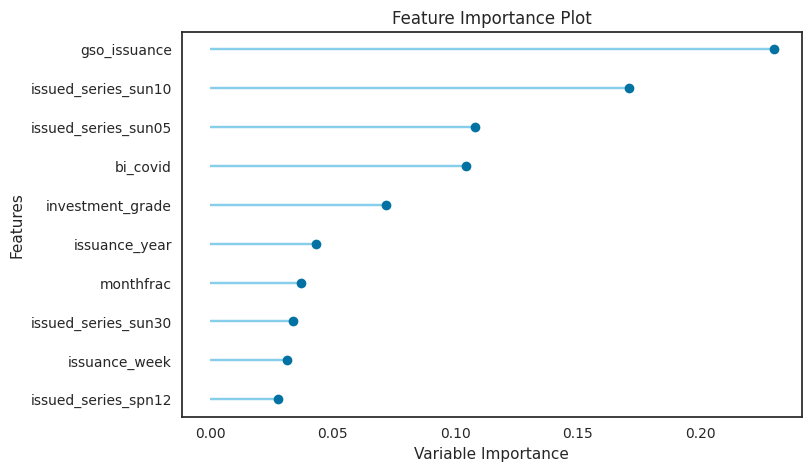

In [ ]:
plot_model(xgb_modified, plot = 'feature')

### Bagging -- 64.29%

In [ ]:
# ensemble with bagging
xgb_bagged = ensemble_model(xgb_raw, method = 'Bagging')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,2177410.2500,10508966035456.0000,3241753.5000,0.6537,0.6193,0.6796
1,2462383.2500,12609807974400.0000,3551029.2500,0.6700,1.6947,0.8304
2,2258019.7500,9515603853312.0000,3084737.2500,0.6864,1.3479,0.6431
3,2494271.5000,17193834119168.0000,4146544.7500,0.6376,1.6438,0.6574
4,2653747.7500,16572982755328.0000,4070992.7500,0.6398,0.9304,2.9188
5,2381161.2500,10677996486656.0000,3267720.5000,0.6269,0.6233,0.7038
6,2459965.2500,15815317389312.0000,3976847.7500,0.6582,1.2787,0.8926
7,2267308.5000,13445532483584.0000,3666815.0000,0.5387,1.5621,0.5727
8,2240172.2500,11271246184448.0000,3357267.7500,0.6834,1.7734,0.6357


Processing:   0%|          | 0/6 [00:00<?, ?it/s]

### Boosting -- 63.94%

In [ ]:
# ensemble with boosting
xgb_boosted = ensemble_model(xgb_raw, method = 'Boosting')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,2196443.2500,10251989417984.0000,3201872.7500,0.6621,0.6127,0.6912
1,2459507.0000,12196956340224.0000,3492414.0000,0.6808,1.6543,0.8516
2,2335643.0000,11081275670528.0000,3328855.0000,0.6348,1.4082,0.6073
3,2606457.2500,16472951750656.0000,4058688.5000,0.6528,1.5775,0.6533
4,2630476.5000,15743012831232.0000,3967746.5000,0.6578,0.8095,1.4550
5,2271945.0000,10324959821824.0000,3213247.5000,0.6392,0.6249,0.6931
6,2347494.0000,14790407749632.0000,3845830.0000,0.6804,1.2706,0.6897
7,2297793.5000,13849251020800.0000,3721458.2500,0.5248,1.5713,0.5855
8,2386056.2500,12424962899968.0000,3524906.0000,0.6510,1.7869,0.7007


Processing:   0%|          | 0/6 [00:00<?, ?it/s]

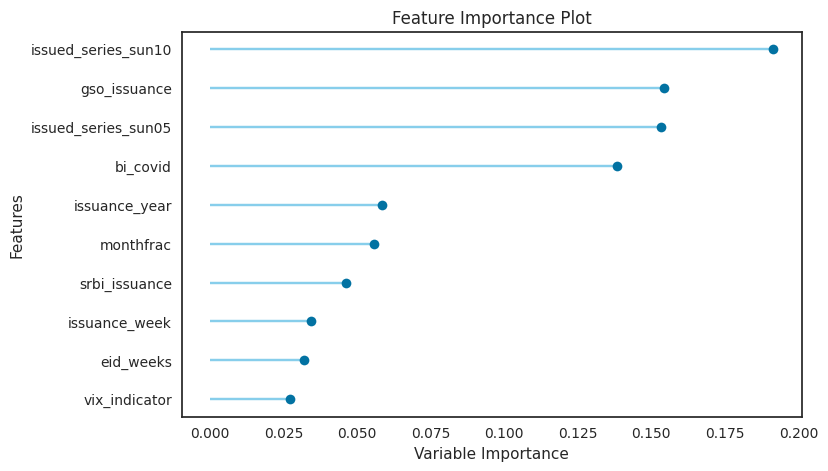

In [ ]:
plot_model(xgb_boosted, plot = 'feature')

## Extra Trees Regressor

### Raw -- 63.91%

In [ ]:
# train a et model with default params
et_raw = create_model('et')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,2205912.2638,11153570387875.4785,3339696.1520,0.6324,0.5743,0.5639
1,2514759.3466,13819176070976.7969,3717415.2406,0.6384,1.4859,0.7360
2,2116435.3742,10080849413953.3984,3175035.3406,0.6678,0.7078,0.4571
3,2581163.3252,17812235895068.3086,4220454.4655,0.6245,1.6809,0.6067
4,2480963.1595,15747027617168.0938,3968252.4639,0.6578,0.8433,2.6880
5,2217874.3497,9806186822931.1602,3131483.1666,0.6573,0.6025,0.6458
6,2458333.5460,14137782446092.0254,3760024.2614,0.6945,1.2306,0.6788
7,2356441.6871,13515366104485.2090,3676325.0814,0.5363,1.3924,0.5797
8,2422833.0307,12156447154493.8066,3486609.6935,0.6585,1.5730,0.6163


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

### Tuning -- 54.09%

In [ ]:
# tune hyperparameters of et
et_tuned = tune_model(et_raw)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,2560790.2151,14675104648210.5449,3830809.9207,0.5164,0.7235,0.9533
1,2861531.2943,15499967132581.0820,3936999.7628,0.5944,1.7989,1.0413
2,2617819.0048,12283150152309.9941,3504732.5365,0.5952,1.3194,0.7837
3,2930558.8321,21997054033507.0586,4690101.7082,0.5363,1.7807,0.9323
4,2977790.0789,18998272763131.6875,4358700.8114,0.5871,1.0279,5.2309
5,2708996.3087,13914794531979.7324,3730253.9501,0.5138,0.7462,0.9814
6,3202306.8023,22083608838211.9922,4699320.0400,0.5228,1.4288,1.4611
7,2487466.0489,15109171089240.8535,3887051.7220,0.4816,1.7751,0.8601
8,2758794.2717,16036549888604.4004,4004566.1299,0.5496,1.8310,0.9581


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 10 folds for each of 10 candidates, totalling 100 fits


Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


### Modifying -- 60.45%

In [ ]:
# define a more comprehensive tuning grid for Random Forest Regressor
et_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [None, 4, 8, 12],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'max_features': ['auto', 'sqrt', None],
    'bootstrap': [True, False]
}

# Tune model with the optimized grid and optimize for Mean Squared Error (mse)
et_modified = tune_model(et_raw, custom_grid=et_grid, optimize='mse', early_stopping=True, choose_better=True)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,2360192.3971,13479790308258.1426,3671483.3934,0.5558,0.6635,0.7904
1,2604007.9770,13912607709883.5527,3729960.8188,0.6359,1.7076,0.8973
2,2336170.7127,10387923328414.3164,3223030.1470,0.6577,1.2279,0.6841
3,2662288.5914,18237193140077.8203,4270502.6800,0.6156,1.7166,0.7845
4,2808814.7543,18362240453883.1172,4285118.4877,0.6009,0.9841,3.8532
5,2457594.8129,11844665932941.8535,3441608.0446,0.5861,0.7044,0.8835
6,2832034.5515,18512679837722.0430,4302636.3822,0.5999,1.3810,1.2834
7,2291187.6468,12751950130847.8184,3570987.2768,0.5625,1.7074,0.7099
8,2585158.3628,14090334604351.6191,3753709.4459,0.6042,1.7704,0.8686


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 10 folds for each of 10 candidates, totalling 100 fits


Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


### Bagging -- 64.60%

In [ ]:
# ensemble with bagging
et_bagged = ensemble_model(et_raw, method = 'Bagging')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,2158641.5896,11294104144139.5547,3360670.1927,0.6278,0.5836,0.6210
1,2506843.2113,13196110432537.9102,3632645.1014,0.6547,1.5911,0.8053
2,2120130.9032,9063487579277.3555,3010562.6682,0.7013,1.1326,0.5302
3,2531268.7376,17351255132002.3770,4165483.7813,0.6342,1.6570,0.6549
4,2534529.9876,16264821452002.7422,4032966.8300,0.6465,0.8711,2.5902
5,2277075.7888,10466238905824.8750,3235156.7050,0.6343,0.6363,0.7265
6,2476402.6688,14421561672562.1113,3797573.1293,0.6883,1.2633,0.7865
7,2267643.2998,12301249196208.1992,3507313.6723,0.5779,1.5781,0.6015
8,2417298.1787,12433776463044.6621,3526156.0463,0.6508,1.7078,0.6737


Processing:   0%|          | 0/6 [00:00<?, ?it/s]

### Boosting -- 65.39%

In [ ]:
# ensemble with boosting
et_boosted = ensemble_model(et_raw, method = 'Boosting')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,2235777.1950,11900400807545.0957,3449695.7558,0.6078,0.5808,0.6134
1,2483691.4456,12769674970652.0703,3573468.1992,0.6658,1.6055,0.7612
2,2113672.2595,9890894938942.3047,3144979.3225,0.6741,1.1591,0.5333
3,2520628.8497,15378415345937.1172,3921532.2702,0.6758,1.6793,0.6367
4,2490396.3006,15456631408761.3574,3931492.2623,0.6641,0.8962,3.0963
5,2207835.4847,9815290876562.3809,3132936.4623,0.6570,0.6120,0.6710
6,2524399.3903,14351076185681.0391,3788281.4290,0.6899,1.2738,0.7347
7,2215339.8466,11989786316866.4609,3462627.0831,0.5886,1.6194,0.5760
8,2403307.6445,11224316401429.1934,3350271.0937,0.6847,1.6423,0.6610


Processing:   0%|          | 0/6 [00:00<?, ?it/s]

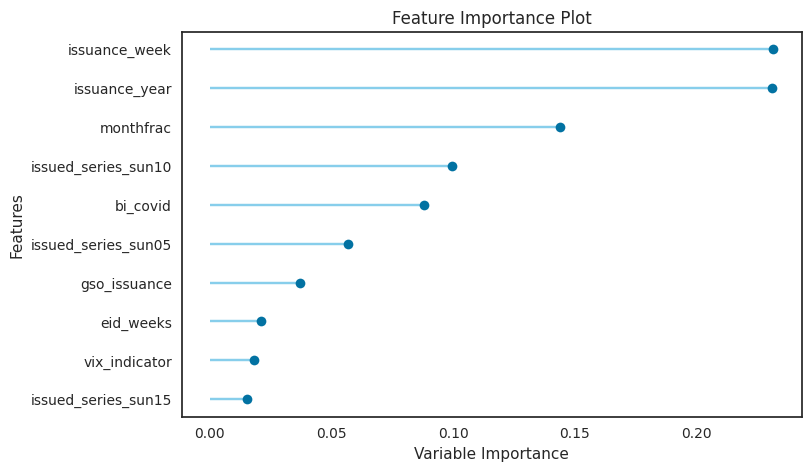

In [ ]:
plot_model(et_boosted, plot = 'feature')

## Random Forest Regressor

### Raw -- 63.54%

In [ ]:
# train a rf model with default params
rf_raw = create_model('rf')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,2192232.0026,10627323099708.8965,3259957.5304,0.6498,0.6092,0.6663
1,2541333.1955,13055397565521.1426,3613225.3688,0.6583,1.6939,0.9258
2,2207692.1441,9567038746623.1035,3093063.0040,0.6847,1.2946,0.5451
3,2560308.2910,16332751004593.8535,4041379.8392,0.6557,1.6972,0.6923
4,2568544.2367,15484155477867.2344,3934991.1662,0.6635,0.9087,3.5915
5,2324166.0757,10652876894169.4043,3263874.5218,0.6278,0.6305,0.7140
6,2446142.4100,15528352983698.1543,3940603.1244,0.6644,1.2654,0.8746
7,2363401.9100,13846503940091.0000,3721089.0798,0.5249,1.6240,0.6287
8,2500807.0450,13473061387137.4883,3670566.9027,0.6216,1.7003,0.7254


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

### Tuning -- 56.69%

In [ ]:
# tune hyperparameters of rf
rf_tuned = tune_model(rf_raw)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,2450617.9045,12885518360828.5781,3589640.4222,0.5753,0.6917,0.8648
1,2817829.0463,14796900879056.6875,3846674.0022,0.6128,1.8142,1.0406
2,2426498.9004,11322521140595.1230,3364895.4130,0.6269,1.3227,0.7344
3,2757832.1864,18827013151846.5625,4339010.6190,0.6031,1.7461,0.8702
4,2977029.0088,18436682644179.8555,4293795.8317,0.5993,1.0155,5.0680
5,2593421.9945,12946285031571.7188,3598094.6391,0.5476,0.7183,0.9030
6,3078418.5342,23051685919312.3867,4801217.1289,0.5018,1.4159,1.4036
7,2466537.8234,14759504788241.1895,3841810.0927,0.4936,1.7697,0.7719
8,2815831.9865,15812256312361.6387,3976462.7890,0.5559,1.8504,0.9702


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 10 folds for each of 10 candidates, totalling 100 fits


Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


### Modifying -- 62.42%

In [ ]:
# define a more comprehensive tuning grid for Random Forest Regressor
rf_grid = {
    'n_estimators': [50, 100, 150, 200],
    'max_depth': [None, 4, 8, 12, 16],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2', None],
    'bootstrap': [True, False]
}

# Tune model with the optimized grid and optimize for Mean Squared Error (mse)
rf_modified = tune_model(rf_raw, custom_grid=rf_grid, optimize='mse', early_stopping=True, choose_better=True)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,2214329.8347,10895472177320.0098,3300829.0136,0.6409,0.6175,0.6941
1,2578277.6834,12795766250564.9258,3577117.0306,0.6651,1.7137,0.9515
2,2270577.1772,9587803885542.7500,3096417.9120,0.6840,1.2950,0.5590
3,2559897.8850,16180602877253.4785,4022512.0108,0.6589,1.7006,0.7162
4,2687693.7688,16676069948442.8535,4083634.4044,0.6376,0.9281,3.5693
5,2381729.3321,11323108022801.6465,3364982.6185,0.6043,0.6532,0.7633
6,2540652.9061,16916468685144.0410,4112963.4918,0.6344,1.2886,0.9472
7,2386027.9516,13909626790737.5527,3729561.2062,0.5227,1.6634,0.6449
8,2532570.1133,14204847298319.1992,3768931.8511,0.6010,1.7064,0.7397


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 10 folds for each of 10 candidates, totalling 100 fits


Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


### Bagging -- 61.51%

In [ ]:
# ensemble with bagging
rf_bagged = ensemble_model(rf_raw, method = 'Bagging')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,2295625.9311,11720446718170.5098,3423513.7970,0.6137,0.6505,0.7642
1,2696668.4970,14289991750732.1406,3780210.5432,0.6260,1.7460,1.0072
2,2300894.3316,9773452692606.2480,3126252.1799,0.6779,1.2767,0.6589
3,2509412.8606,16010049604898.6953,4001256.0034,0.6625,1.7305,0.7827
4,2743023.3248,16516792997138.7109,4064085.7517,0.6410,0.9867,5.0650
5,2457696.6439,11693791779802.6133,3419618.6600,0.5914,0.6767,0.8094
6,2745272.3600,18539876915052.1953,4305795.7354,0.5993,1.3331,1.0501
7,2364733.4118,13182578217477.7617,3630782.0394,0.5477,1.6914,0.7007
8,2567897.8273,14283299043507.0430,3779325.2101,0.5988,1.7797,0.7906


Processing:   0%|          | 0/6 [00:00<?, ?it/s]

### Boosting -- 64.71%

In [ ]:
# ensemble with boosting
rf_boosted = ensemble_model(rf_raw, method = 'Boosting')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,2175214.8747,10505689655867.6738,3241248.1633,0.6538,0.6248,0.7274
1,2532140.5066,12400797744999.7012,3521476.6427,0.6755,1.7224,0.9328
2,2231003.7267,9529385154684.6289,3086970.2225,0.6860,1.2824,0.6555
3,2557794.5231,16804815880833.5684,4099367.7416,0.6458,1.7063,0.7353
4,2610436.3518,14873935450293.8340,3856674.1436,0.6767,0.9497,3.5326
5,2291289.5401,9664428923935.5762,3108766.4634,0.6623,0.6540,0.7756
6,2461912.1534,15463717514762.2754,3932393.3571,0.6658,1.2881,0.8797
7,2338475.0686,12953469095756.6328,3599092.8157,0.5555,1.6449,0.6533
8,2666640.4747,13665638899298.8730,3696706.4935,0.6162,1.7681,0.8775


Processing:   0%|          | 0/6 [00:00<?, ?it/s]

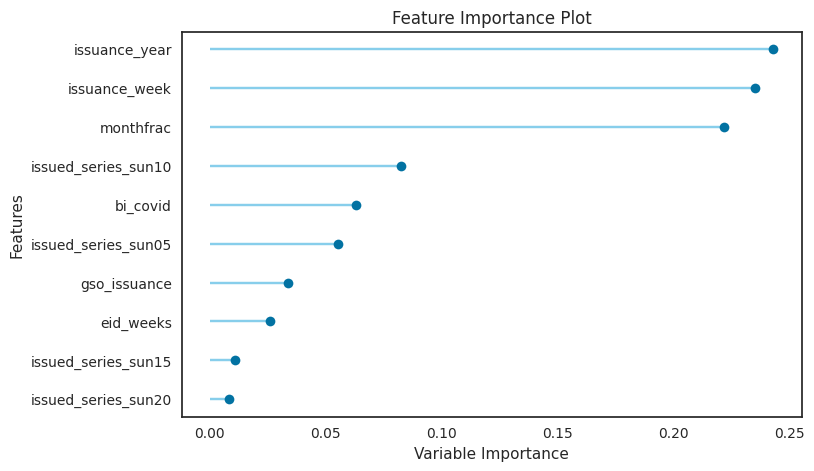

In [ ]:
plot_model(rf_boosted, plot = 'feature')

# Choosen

## Blended -- 62.47%

In [ ]:
# Blend the Boosted Ensembles
blended = blend_models(estimator_list=[lightgbm_modified, xgb_modified, et_boosted, rf_boosted], fold=10)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,1995364.3818,9704789572841.7422,3115251.1252,0.6802,0.5957,0.6228
1,2405030.8432,10882969094292.5391,3298934.5393,0.7152,1.6347,0.8106
2,2247086.7519,10019057881846.6172,3165289.5416,0.6698,1.2920,0.6315
3,2354768.6769,13761825367605.3828,3709693.4331,0.7099,1.5754,0.6292
4,2443927.4002,14296905377172.1250,3781124.8825,0.6893,0.8894,2.2276
5,2152482.0173,8707492063649.5693,2950845.9912,0.6957,0.6125,0.6943
6,2285892.3065,13332154543225.8164,3651322.3007,0.7119,1.1830,0.7815
7,2182769.9827,11876179834295.8691,3446183.3721,0.5925,1.5064,0.5628
8,2301997.9313,11190141818791.1973,3345166.9344,0.6857,1.7509,0.6607


Processing:   0%|          | 0/6 [00:00<?, ?it/s]

In [ ]:
predict_model(blended);

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Voting Regressor,2334059.9573,11041470090760.3691,3322870.7605,0.6247,0.6122,0.7083


In [ ]:
# plot_model(blended, plot = 'residuals')

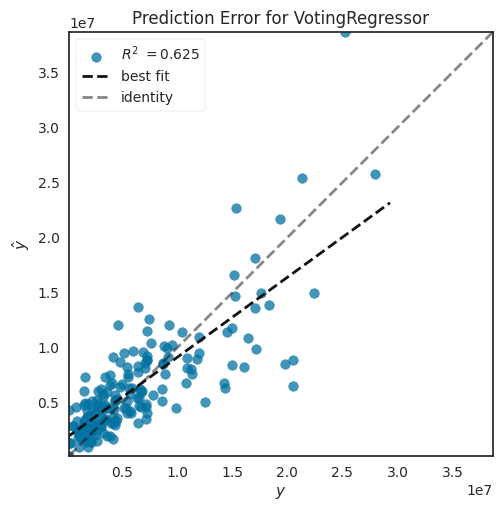

In [ ]:
plot_model(blended, plot = 'error')

## Stacked -- 61.79%

In [ ]:
stacked = stack_models(estimator_list=[lightgbm_modified, xgb_modified, et_boosted, rf_boosted])

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,2047983.3770,9917628922972.3457,3149226.7183,0.6732,0.6064,0.6575
1,2392969.5235,11435184457526.7637,3381594.9576,0.7007,1.5921,0.7388
2,2228432.3485,10062100799657.6602,3172081.4617,0.6684,1.3552,0.6172
3,2378634.9559,13998512208130.0332,3741458.5669,0.7049,1.5204,0.5958
4,2409759.1452,14179014048353.0254,3765503.1601,0.6918,0.8304,1.6348
5,2111396.4039,8626437897625.5557,2937079.8249,0.6986,0.6067,0.6863
6,2296590.6238,13018149679822.9727,3608067.3053,0.7187,1.2869,0.7687
7,2136017.3886,11664584894900.7734,3415345.5015,0.5998,1.5439,0.5380
8,2254905.7010,10845432489713.5430,3293240.4239,0.6954,1.7272,0.6210


Processing:   0%|          | 0/6 [00:00<?, ?it/s]

In [ ]:
predict_model(stacked);

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Stacking Regressor,2332567.0715,11240846278297.6289,3352737.1323,0.6179,0.6694,0.6623


In [ ]:
# plot_model(stacked, plot = 'residuals')

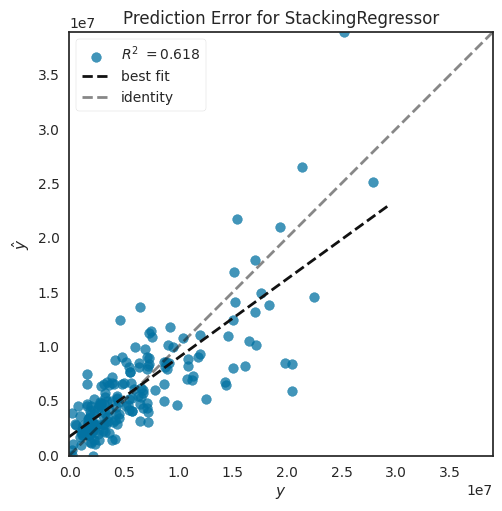

In [ ]:
plot_model(stacked, plot = 'error')

## Finalizing -- 95.42%

In [ ]:
final = finalize_model(blended)
predict_model(final);

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Voting Regressor,903623.2390,1347438567344.0005,1160792.2154,0.9542,0.3137,0.2706


In [ ]:
save_model(final, '/content/drive/MyDrive/00database/20240129_blended03')

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=Memory(location=None),
          steps=[('numerical_imputer',
                  TransformerWrapper(include=['issuance_year', 'issuance_week',
                                              'monthfrac', 'eid_weeks',
                                              'srbi_issuance', 'vix_indicator',
                                              'bi_covid', 'gso_issuance',
                                              'investment_grade'],
                                     transformer=SimpleImputer())),
                 ('categorical_imputer',
                  TransformerWrapper(include=['issued_series'],
                                     transformer=SimpleImpute...
                                                            n_estimators=100,
                                                            n_jobs=-1,
                                                            num_parallel_tree=None,
                                                            random_state=123,

# Lelang 30 Jan 2024

## Load

In [7]:
lelang20240130 = pd.read_excel('/content/drive/MyDrive/00database/db_monthfrac.xlsx', sheet_name='lelang20240130')
lelang20240130['issuance_date'] = pd.to_datetime(lelang20240130['issuance_date'], format='%d/%m/%Y')
lelang20240130.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8 entries, 0 to 7
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   issued_series     8 non-null      object        
 1   issuance_date     8 non-null      datetime64[ns]
 2   issuance_year     8 non-null      int64         
 3   issuance_week     8 non-null      int64         
 4   monthfrac         8 non-null      int64         
 5   eid_weeks         8 non-null      int64         
 6   srbi_issuance     8 non-null      int64         
 7   vix_indicator     8 non-null      int64         
 8   bi_covid          8 non-null      int64         
 9   gso_issuance      8 non-null      int64         
 10  investment_grade  8 non-null      int64         
dtypes: datetime64[ns](1), int64(9), object(1)
memory usage: 832.0+ bytes


## Predict

In [9]:
# load model
blended03_20240129 = load_model("/content/drive/MyDrive/00database/20240129_blended03")

# predict model on new_data
predict03= predict_model(blended03_20240129, data = lelang20240130)
predict03

# predict model on new_data
# predict03= predict_model(final, data = lelang20240130)
# predict03

Transformation Pipeline and Model Successfully Loaded


,issued_series,issuance_date,issuance_year,issuance_week,monthfrac,eid_weeks,srbi_issuance,vix_indicator,bi_covid,gso_issuance,investment_grade,prediction_label
0,spn03,2024-01-30,2024,5,3,0,1,0,0,0,1,4.380837e+06
1,spn12,2024-01-30,2024,5,11,0,1,0,0,0,1,8.607249e+06
2,sun05,2024-01-30,2024,5,62,0,1,0,0,0,1,1.930124e+07
3,sun08,2024-01-30,2024,5,80,0,1,0,0,0,1,7.646262e+06
4,sun10,2024-01-30,2024,5,120,0,1,0,0,0,1,1.843286e+07
5,sun15,2024-01-30,2024,5,172,0,1,0,0,0,1,4.562450e+06
6,sun20,2024-01-30,2024,5,232,0,1,0,0,0,1,3.847862e+06
7,sun30,2024-01-30,2024,5,365,0,1,0,0,0,1,5.281845e+06


In [10]:
# @title Lelang 20240130: Per series

# !pip install --upgrade pip
# !pip install tabulate

import tabulate

# Incoming bid per series
predict04 = predict03[['issued_series', 'issuance_date', 'prediction_label']]

# Create a new column with formatted dates
predict04['issuance_date'] = predict04['issuance_date'].dt.strftime('%Y-%m-%d')

# Format the 'prediction_label' column
predict04['prediction_label'] = predict04['prediction_label'].apply(lambda x: '{:,.2f} trillion'.format(x / 1_000_000))

# Convert the DataFrame to a list of dictionaries for tabulate
table_data = predict04.to_dict(orient='records')

# Specify the column alignments
column_alignments = {'issued_series': 'left', 'issuance_date': 'center', 'prediction_label': 'right'}

# Display the formatted DataFrame using tabulate
formatted_table = tabulate.tabulate(table_data, headers="keys", floatfmt=".2f", showindex=False, colalign=list(column_alignments.values()), tablefmt="pipe")

print(formatted_table)

| issued_series   |  issuance_date  |   prediction_label |
|:----------------|:---------------:|-------------------:|
| spn03           |   2024-01-30    |      4.38 trillion |
| spn12           |   2024-01-30    |      8.61 trillion |
| sun05           |   2024-01-30    |     19.30 trillion |
| sun08           |   2024-01-30    |      7.65 trillion |
| sun10           |   2024-01-30    |     18.43 trillion |
| sun15           |   2024-01-30    |      4.56 trillion |
| sun20           |   2024-01-30    |      3.85 trillion |
| sun30           |   2024-01-30    |      5.28 trillion |


In [11]:
# @title Lelang 20240130: Total

# Sum total incoming bid
incoming_bid = predict03['prediction_label'].sum()

# Round to two decimal places
rounded_bid = round(incoming_bid, 2)
formatted_rounded_bid = 'Rp{:,.2f} million'.format(rounded_bid)

# Adjust to the nearest thousand
formatted_incoming_bid = 'Rp{:,.2f} trillion'.format(rounded_bid / 1000000)

output_message = f"""
According to a blended machine learning algorithm model with an R-squared value of 62.47%,
the estimated incoming bid for the next issuance is approximately {formatted_rounded_bid}
or {formatted_incoming_bid}.
"""

print(output_message)



According to a blended machine learning algorithm model with an R-squared value of 62.47%,
the estimated incoming bid for the next issuance is approximately Rp72,060,609.69 million
or Rp72.06 trillion.

